In [29]:
import numpy as np
import pandas as pd

def read_data_from_UCI():
    """Reads the bank-marketing data table from a zip file directly from UCI"""
    import zipfile
    import io
    from urllib import request

    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
    with request.urlopen(url) as r:
        with zipfile.ZipFile(io.BytesIO(r.read())) as zf:
            csv_file = zf.open("bank-additional/bank-additional-full.csv")
            df = pd.read_csv(csv_file, sep=";")
    return df

In [30]:
data = read_data_from_UCI()
data.shape

(41188, 21)

In [31]:
print(data['y'].unique())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = pd.Series(le.fit_transform(data['y']))
y.mean()

['no' 'yes']


0.11265417111780131

In [32]:
print(data['contact'].unique())
a = pd.Series(le.fit_transform(data['contact']))
a.mean()

['telephone' 'cellular']


0.3652520151500437

In [33]:
confounders = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [34]:
confounders += ['month', 'campaign']

In [35]:
X = data[confounders]
X.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
month              object
campaign            int64
dtype: object

In [36]:
X = pd.get_dummies(X, prefix_sep='=', drop_first=True)
X.head()

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,campaign,job=blue-collar,...,poutcome=success,month=aug,month=dec,month=jul,month=jun,month=mar,month=may,month=nov,month=oct,month=sep
0,56,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,57,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,37,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,40,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,56,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [37]:
from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
#lr = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)
#lr = GradientBoostingClassifier()
ipw = IPW(lr)

In [38]:
ipw.fit(X, a)

IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=1000))

In [39]:
propMatrix = ipw.compute_propensity_matrix(X, a)

In [40]:
# propMatrix

In [41]:
# weight_matrix = propMatrix.rdiv(1.0)

In [42]:
# w = robust_lookup(weight_matrix, a)
# w

In [43]:
# X.to_json("../public/cohort_confounds.json", orient="records")
# propMatrix.to_json("../public/cohort_propensity.json", orient="records")
# a.to_json("../public/cohort_treatment.json", orient="records")

In [44]:
import matplotlib.pyplot as plt

weights = np.ones_like(propMatrix[1])/float(len(propMatrix[1]))

# plt.hist(propMatrix[1], bins=50, weights=weights)

In [45]:
outcomes = ipw.estimate_population_outcome(X, a, y)
outcomes

0    0.155379
1    0.223001
dtype: float64

/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/causallib/evaluation/weight_evaluator.py:451: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  "expected": [fold_predictions.propensity.append(1 - fold_predictions.propensity)
/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/causallib/evaluation/weight_evaluator.py:458: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  "expected": [pd.Series(data=targets.max(), index=fold_predictions.propensity.index).append(
/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/causallib/evaluation/weight_evaluator.py:465: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  "expected": [fold_predictions.propensity.append(fold_predictions.propensity)


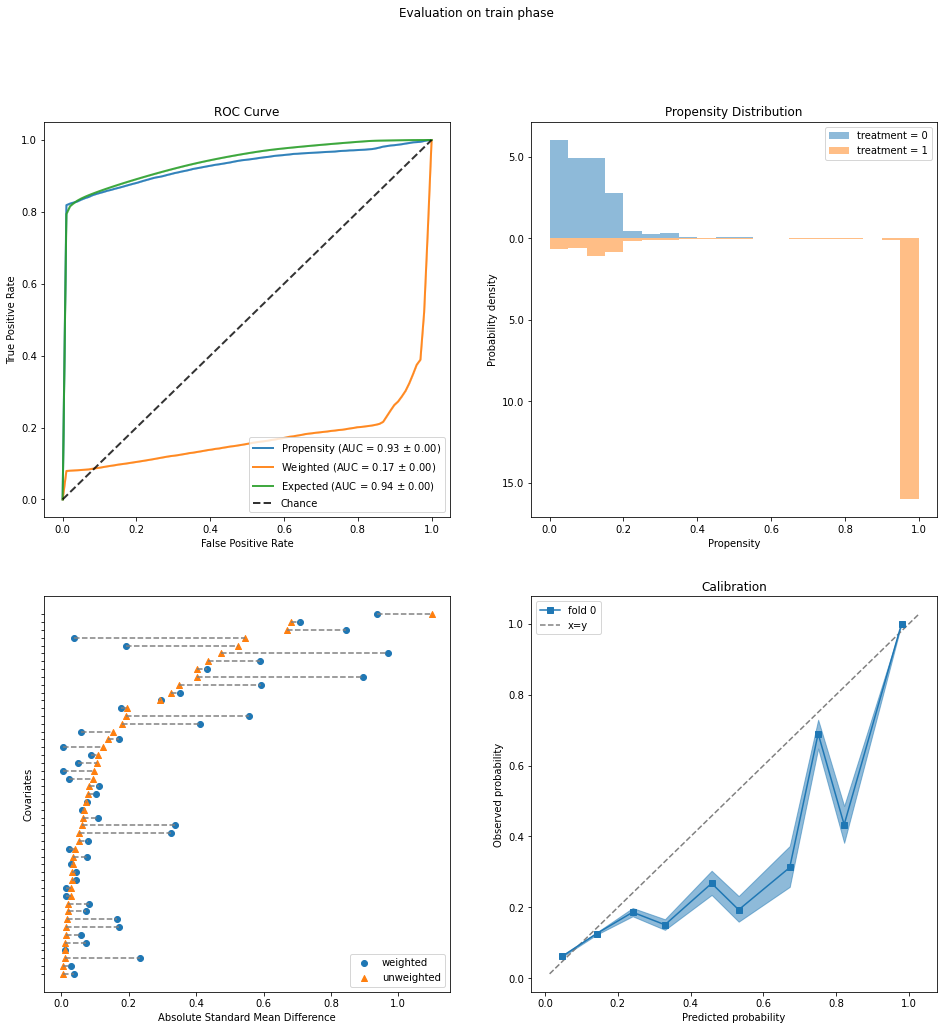

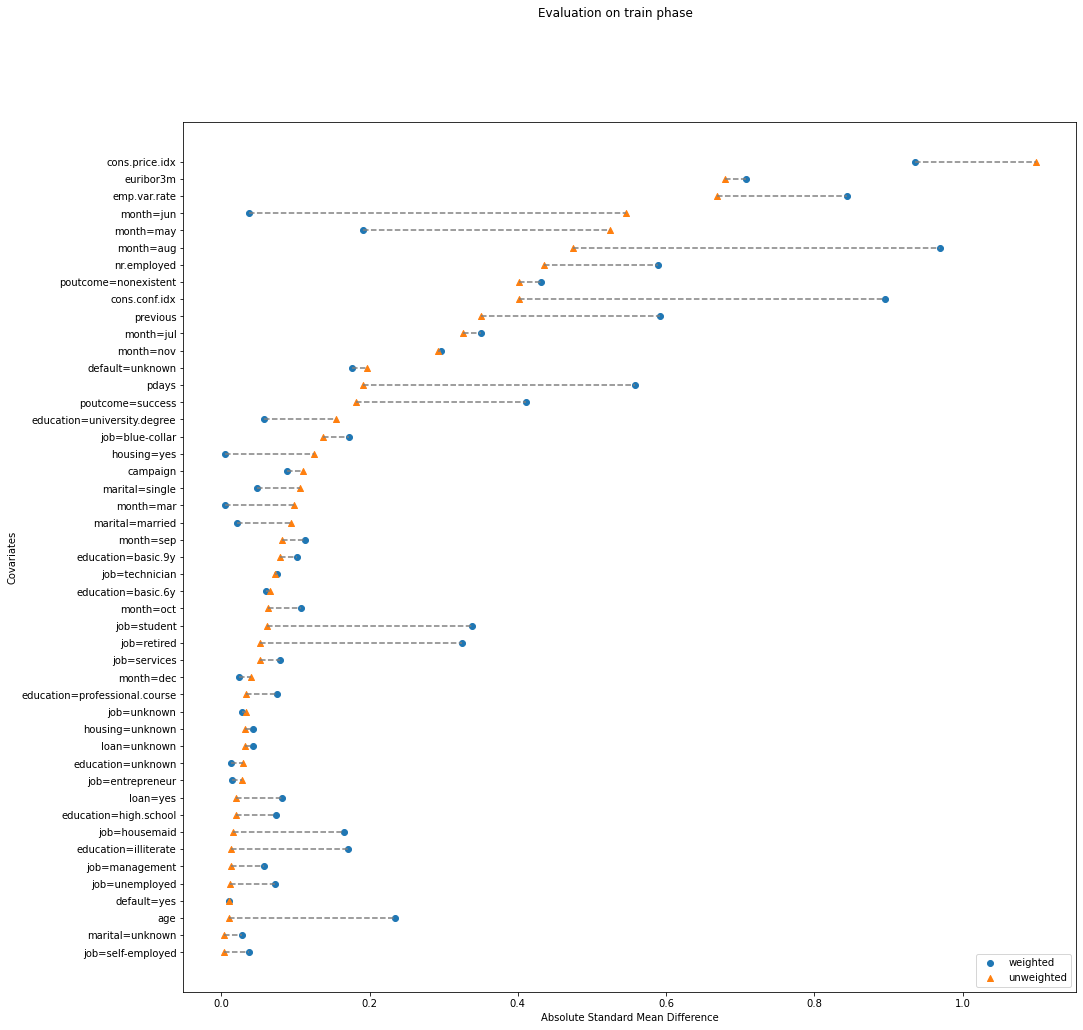

In [46]:
from causallib.evaluation import PropensityEvaluator

evaluator = PropensityEvaluator(ipw)
eval_results = evaluator.evaluate_simple(X, a, y, plots=["roc_curve", "weight_distribution", "covariate_balance_love", "calibration"])
evaluator.evaluate_simple(X, a, y, plots=["covariate_balance_love"])

In [49]:
indExclude = (X['cons.price.idx'] > 93.92) & (X['euribor3m'] > 4.5)
a[indExclude].mean()
# indExclude

1.0

In [50]:
y2 = y.loc[~indExclude]
a2 = a.loc[~indExclude]
X2 = X.loc[~indExclude]
print(y.mean())
print(a.mean())

0.11265417111780131
0.3652520151500437


In [51]:
ipw.fit(X2, a2)

IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=1000))

In [52]:
propMatrix2 = ipw.compute_propensity_matrix(X2, a2)

In [53]:
# X.to_json("../public/cohort2_confounds.json", orient="records")
# propMatrix2.to_json("../public/cohort2_propensity.json", orient="records")
# a.to_json("../public/cohort2_treatment.json", orient="records")

/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/causallib/evaluation/weight_evaluator.py:451: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  "expected": [fold_predictions.propensity.append(1 - fold_predictions.propensity)
/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/causallib/evaluation/weight_evaluator.py:458: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  "expected": [pd.Series(data=targets.max(), index=fold_predictions.propensity.index).append(
/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/causallib/evaluation/weight_evaluator.py:465: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  "expected": [fold_predictions.propensity.append(fold_predictions.propensity)


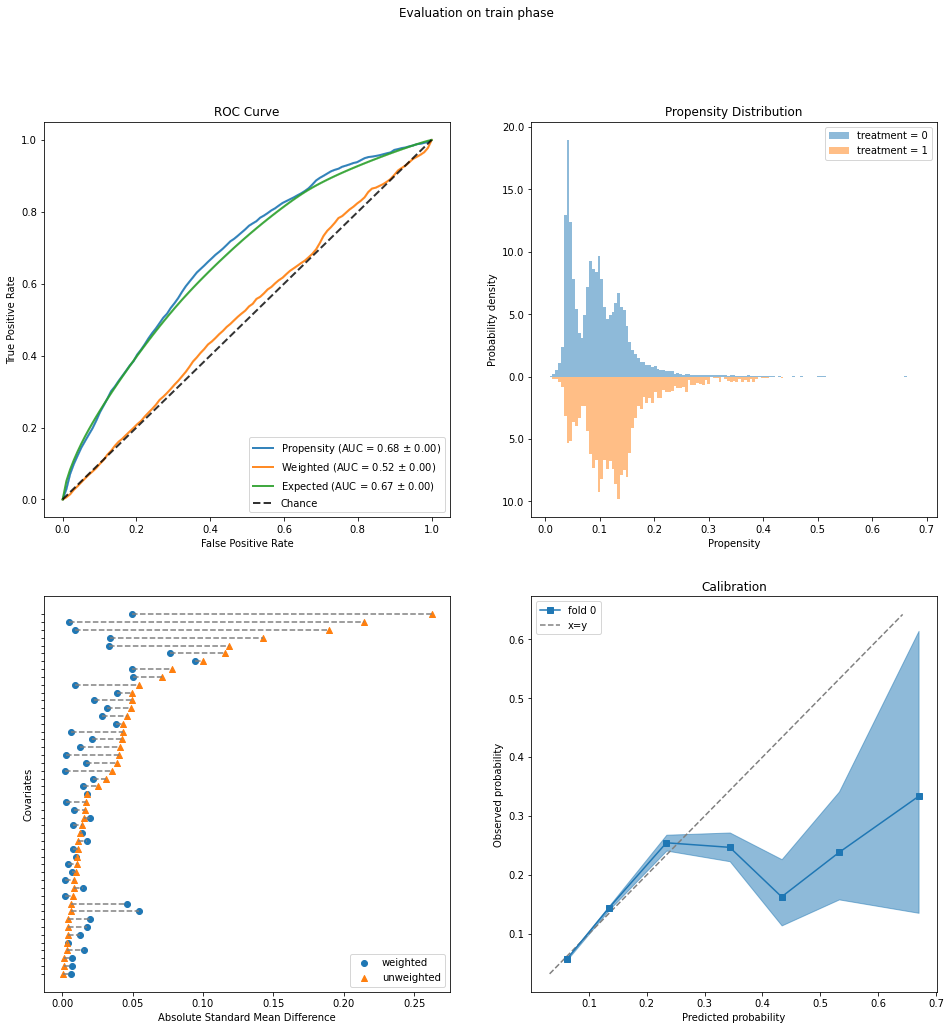

In [54]:
evaluator = PropensityEvaluator(ipw)
eval_results = evaluator.evaluate_simple(X2, a2, y2, plots=["roc_curve", "weight_distribution", "covariate_balance_love", "calibration"])

In [21]:
outcomes = ipw.estimate_population_outcome(X, a, y)
print(outcomes)
ipw.estimate_effect(outcomes[0], outcomes[1], effect_types=['diff','ratio'])

0    0.150399
1    0.120746
dtype: float64


diff     0.029653
ratio    1.245578
dtype: float64

In [19]:
# SMD = eval_results.scores[1]
# SMD.reset_index(inplace=True)
# SMD = SMD.rename(columns = {'index': 'covariate'})
# SMD

In [63]:
# SMD.to_json("../public/TCSMD.json", orient="records")

### Calculate SMD (Manual)

In [65]:
group_level = 1
cur_treated_mask = a == group_level

In [85]:
w

0        1.015517
1        1.015202
2        1.015397
3        1.014535
4        1.015136
           ...   
41183    1.374862
41184    1.381518
41185    1.401429
41186    1.351231
41187    1.176692
Length: 41188, dtype: float64

In [86]:
x = X["cons.price.idx"]
x_treated = x.loc[cur_treated_mask]
w_treated = w.loc[cur_treated_mask]
x_untreated = x.loc[~cur_treated_mask]
w_untreated = w.loc[~cur_treated_mask]

In [99]:
x_treated, x_untreated

(0        93.994
 1        93.994
 2        93.994
 3        93.994
 4        93.994
           ...  
 41129    94.767
 41136    94.767
 41155    94.767
 41166    94.767
 41171    94.767
 Name: cons.price.idx, Length: 15044, dtype: float64,
 12357    93.918
 12358    93.918
 12360    93.918
 12361    93.918
 12363    93.918
           ...  
 41183    94.767
 41184    94.767
 41185    94.767
 41186    94.767
 41187    94.767
 Name: cons.price.idx, Length: 26144, dtype: float64)

In [97]:
def calc_unweighted_standardized_mean_differences(x, y, weighted_var=False):
    r"""
    Standardized mean difference: frac{\mu_1 - \mu_2 }{\sqrt{\sigma_1^2 + \sigma_2^2}}

    References:
        [1]https://cran.r-project.org/web/packages/cobalt/vignettes/cobalt_A0_basic_use.html#details-on-calculations
        [2]https://en.wikipedia.org/wiki/Strictly_standardized_mean_difference#Concept

    Note on variance:
    - The variance is calculated on unadjusted to avoid paradoxical situation when adjustment decreases both the
      mean difference and the spread of the sample, yielding a larger smd than that prior to adjustment,
      even though the adjusted groups are now more similar [1].
    - The denominator is as depicted in the "statistical estimation" section:
      https://en.wikipedia.org/wiki/Strictly_standardized_mean_difference#Statistical_estimation,
      namely, disregarding the covariance term [2], and is unweighted as suggested above in [1].
    """
    numerator = np.average(x) - np.average(y)
    
    denominator = np.sqrt(np.nanvar(x) + np.nanvar(y))
    
    print("numerator", numerator, "denominator", denominator)
    
    if np.isfinite(denominator) and np.isfinite(numerator) and denominator != 0:
        bias = numerator / denominator
    else:
        bias = np.nan
    return bias

In [98]:
calc_unweighted_standardized_mean_differences(x_treated, x_untreated)

94.02699315341664 93.31595696909427
numerator 0.7110361843223671 denominator 0.6471677197338351


1.0986892000960735

In [100]:
def calc_weighted_standardized_mean_differences(x, y, wx, wy, weighted_var=False):
    r"""
    Standardized mean difference: frac{\mu_1 - \mu_2 }{\sqrt{\sigma_1^2 + \sigma_2^2}}

    References:
        [1]https://cran.r-project.org/web/packages/cobalt/vignettes/cobalt_A0_basic_use.html#details-on-calculations
        [2]https://en.wikipedia.org/wiki/Strictly_standardized_mean_difference#Concept

    Note on variance:
    - The variance is calculated on unadjusted to avoid paradoxical situation when adjustment decreases both the
      mean difference and the spread of the sample, yielding a larger smd than that prior to adjustment,
      even though the adjusted groups are now more similar [1].
    - The denominator is as depicted in the "statistical estimation" section:
      https://en.wikipedia.org/wiki/Strictly_standardized_mean_difference#Statistical_estimation,
      namely, disregarding the covariance term [2], and is unweighted as suggested above in [1].
    """
    numerator = np.average(x, weights=wx) - np.average(y, weights=wy)
    if weighted_var:
        var = lambda vec, weights: np.average((vec - np.average(vec, weights=weights)) ** 2, weights=weights)
        denominator = np.sqrt(var(x, wx) + var(y, wy))
    else:
        denominator = np.sqrt(np.nanvar(x) + np.nanvar(y))
    if np.isfinite(denominator) and np.isfinite(numerator) and denominator != 0:
        bias = numerator / denominator
    else:
        bias = np.nan
        
    print("numerator:", numerator, "denominator:", denominator)
    return bias


In [101]:
calc_weighted_standardized_mean_differences(x_treated, x_untreated, w_treated, w_untreated)

numerator: -0.593502226419929 denominator: 0.6471677197338351


-0.9170763749836326